In [46]:
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
pd.options.display.max_columns = None

from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, log_loss

from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

In [2]:
# Load preprocessed dataset

PREPROCESSED_DF_PATH = 'preprocessed_applications_df.dataframe.pd'
main_df = pickle.load( open(PREPROCESSED_DF_PATH, 'rb') )

In [3]:
# Remove redundant features

target_ids = main_df['appl_id']
target_labels = main_df['df']

features_to_drop = [
    'appl_id', 'client_id',
    'app_crtime', 'birth', 'pass_bdate', 'lived_since', 'is_same_reg_lived_since', 'jobsworksince',
    'df'  # target feature
]
main_df = main_df.drop( features_to_drop, axis=1 )

In [4]:
# Encode several features

features_to_encode = [
    'gender',
    'top_browser', 'top_platform',
    'total_devices_cnt',
    'visit_top_dayofweek', 'visit_top_dayhour',
    'binned_visit_top_dayhour', 
    'binned_fam_status', 'binned_quantity_child', 'binned_max_age_child',
    'binned_property',
    'binned_region', 'binned_region_reg',
    'binned_work_experience', 'binned_empl_state', 'binned_empl_type', 'binned_empl_worker_count', 
    'binned_education_area', 'binned_education',
    'binned_days_from_birth', 'binned_days_from_passbdate',
    'app_month_num'
]

for feature_name in features_to_encode:
    main_df[feature_name] = main_df[feature_name].astype('category')

main_encoded_df = pd.get_dummies(
    main_df, columns=features_to_encode, drop_first=True
)

In [5]:
def draw_learning_curve(estimator, X_tr, y_tr):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_tr, y_tr, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1, color="g"
    )
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o-', color="r", label="Training score"
    )
    plt.plot(
        train_sizes,
        val_scores_mean,
        'o-', color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    plt.show()

In [6]:
# Prepare train df and train target labels (no upsampling)

train_labels = target_labels[ target_labels.isnull() == False ]
train_df = main_encoded_df.loc[train_labels.index, :]

enc_train_labels = train_labels.map({
    'bad': 0, 'good': 1
})

In [18]:
def try_model( data_df, target_df ):
    skf = StratifiedKFold(
        n_splits=4,
        shuffle=True
    )

    idx = 0
    for train_idx, val_idx in skf.split(data_df, target_df):
        X_tr, X_val = data_df.iloc[train_idx, :], data_df.iloc[val_idx, :]
        y_tr, y_val = target_df.iloc[train_idx], target_df.iloc[val_idx]

        idx += 1
        display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))
        
        display( pd.Series(y_tr).value_counts() )

        lgbm_model = LGBMClassifier(
            metric='binary_error',
            objective='binary',
            n_estimators=50,
            learning_rate=0.05,
            scale_pos_weight=0.32,
            n_jobs=4,
        )
        lgbm_model.fit(X_tr, y_tr)

        val_y_pred = lgbm_model.predict(X_val)
        print( 'accuracy', lgbm_model.score(X_val, y_val) )
        print( 'recall', recall_score(y_val, val_y_pred ) )
        print( 'precision', precision_score(y_val, val_y_pred) )
        print( '\nconfusion matrix:\n', confusion_matrix(y_val, val_y_pred) )
        print( classification_report(y_val, val_y_pred) )

        draw_learning_curve( lgbm_model, X_tr, y_tr )

'fold 1/4'

1    2254
0     742
Name: df, dtype: int64

accuracy 0.643
recall 0.7327127659574468
precision 0.7793493635077794

confusion matrix:
 [[ 92 156]
 [201 551]]
              precision    recall  f1-score   support

           0       0.31      0.37      0.34       248
           1       0.78      0.73      0.76       752

    accuracy                           0.64      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.66      0.64      0.65      1000



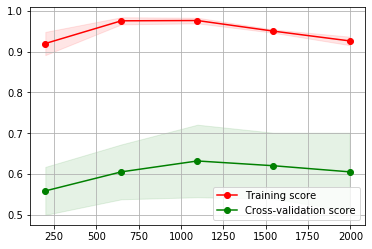

'fold 2/4'

1    2254
0     742
Name: df, dtype: int64

accuracy 0.642
recall 0.7353723404255319
precision 0.776685393258427

confusion matrix:
 [[ 89 159]
 [199 553]]
              precision    recall  f1-score   support

           0       0.31      0.36      0.33       248
           1       0.78      0.74      0.76       752

    accuracy                           0.64      1000
   macro avg       0.54      0.55      0.54      1000
weighted avg       0.66      0.64      0.65      1000



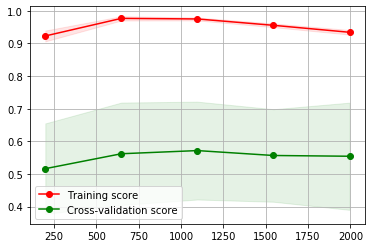

'fold 3/4'

1    2255
0     743
Name: df, dtype: int64

accuracy 0.6342685370741483
recall 0.7270306258322237
precision 0.773371104815864

confusion matrix:
 [[ 87 160]
 [205 546]]
              precision    recall  f1-score   support

           0       0.30      0.35      0.32       247
           1       0.77      0.73      0.75       751

    accuracy                           0.63       998
   macro avg       0.54      0.54      0.54       998
weighted avg       0.66      0.63      0.64       998



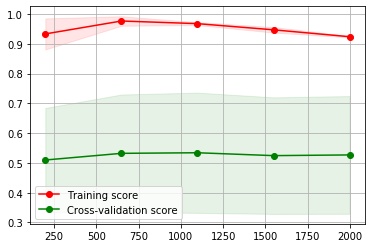

'fold 4/4'

1    2255
0     743
Name: df, dtype: int64

accuracy 0.656312625250501
recall 0.7603195739014648
precision 0.7779291553133515

confusion matrix:
 [[ 84 163]
 [180 571]]
              precision    recall  f1-score   support

           0       0.32      0.34      0.33       247
           1       0.78      0.76      0.77       751

    accuracy                           0.66       998
   macro avg       0.55      0.55      0.55       998
weighted avg       0.66      0.66      0.66       998



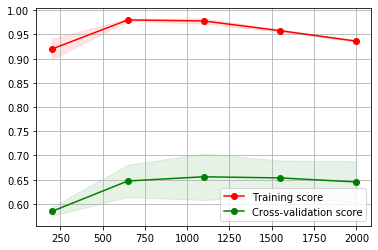

In [19]:
# Try out lgbm classifier without upsampling on StratifiedFold

# Results - too bad

try_model(
    train_df, enc_train_labels
)

In [20]:
# Overview feature_importances

# Note: the only use in this cell is to identify important features
lgbm_model = LGBMClassifier(
    metric='binary_error',
    objective='binary',
    n_estimators=50,
    learning_rate=0.05,
    scale_pos_weight=0.32,
    n_jobs=4,
)
lgbm_model.fit( train_df, enc_train_labels )

# Identify important features
model0_feat_imp = pd.DataFrame({
    'imp_name': train_df.columns,
    'imp_val': lgbm_model.booster_.feature_importance(importance_type='gain')
}).sort_values(by='imp_val', ascending=False)

display(model0_feat_imp.head(10))
display(model0_feat_imp.tail(20))

features_to_drop = model0_feat_imp[model0_feat_imp['imp_val'] < 50]['imp_name'].values

display(features_to_drop)

,imp_name,imp_val
29,days_from_birth,402.165289
30,days_from_passbdate,399.883700
33,employ_to_birth_ratio,375.712979
24,weird_sqrcost_inc,370.326999
25,intrct_income_cost,361.286801
15,total_time_spent,358.150710
16,avg_time_per_page,332.819910
23,weird_sqrtcost_inc,257.721621
31,days_from_jobsworksince,241.899300
21,inc_cost_diff,241.392241


,imp_name,imp_val
71,visit_top_dayhour_17,0.0
72,visit_top_dayhour_18,0.0
73,visit_top_dayhour_19,0.0
75,visit_top_dayhour_21,0.0
76,visit_top_dayhour_22,0.0
77,visit_top_dayhour_23,0.0
60,visit_top_dayhour_6,0.0
59,visit_top_dayhour_5,0.0
58,visit_top_dayhour_4,0.0
82,binned_fam_status_3,0.0


array(['binned_education_area_2', 'region', 'visit_top_dayhour_12',
       'interct_region_regionreg', 'binned_visit_top_dayhour_2',
       'binned_work_experience_4', 'binned_education_2',
       'binned_quantity_child_1', 'binned_education_area_5',
       'app_month_num_9', 'app_month_num_10',
       'binned_empl_worker_count_3', 'binned_empl_worker_count_2',
       'binned_region_reg_3', 'visit_top_dayofweek_2', 'top_platform_2',
       'binned_region_2', 'visit_top_dayhour_8',
       'binned_days_from_birth_2', 'binned_education_area_3',
       'top_browser_5', 'top_platform_5', 'visit_top_dayhour_10',
       'visit_top_dayofweek_6', 'binned_quantity_child_2',
       'flg_inc_eq_cost', 'binned_days_from_birth_3',
       'binned_max_age_child_3', 'visit_days_cnt', 'visit_top_dayhour_9',
       'fam_status', 'quantity_child', 'top_browser_3',
       'binned_work_experience_5', 'top_browser_6',
       'visit_top_dayhour_15', 'binned_max_age_child_2',
       'binned_work_experience_3',

'fold 1/4'

1    2254
0     742
Name: df, dtype: int64

accuracy 0.615
recall 0.699468085106383
precision 0.7678832116788321

confusion matrix:
 [[ 89 159]
 [226 526]]
              precision    recall  f1-score   support

           0       0.28      0.36      0.32       248
           1       0.77      0.70      0.73       752

    accuracy                           0.61      1000
   macro avg       0.53      0.53      0.52      1000
weighted avg       0.65      0.61      0.63      1000



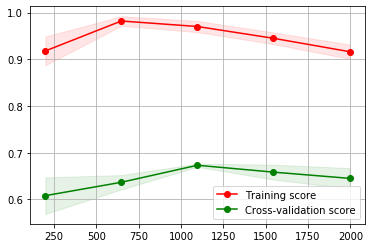

'fold 2/4'

1    2254
0     742
Name: df, dtype: int64

accuracy 0.625
recall 0.7047872340425532
precision 0.7759882869692533

confusion matrix:
 [[ 95 153]
 [222 530]]
              precision    recall  f1-score   support

           0       0.30      0.38      0.34       248
           1       0.78      0.70      0.74       752

    accuracy                           0.62      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.66      0.62      0.64      1000



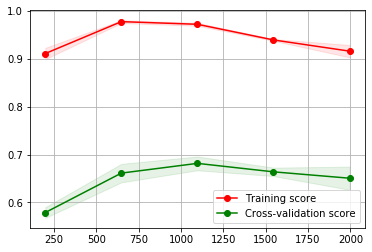

'fold 3/4'

1    2255
0     743
Name: df, dtype: int64

accuracy 0.657314629258517
recall 0.7549933422103862
precision 0.7820689655172414

confusion matrix:
 [[ 89 158]
 [184 567]]
              precision    recall  f1-score   support

           0       0.33      0.36      0.34       247
           1       0.78      0.75      0.77       751

    accuracy                           0.66       998
   macro avg       0.55      0.56      0.56       998
weighted avg       0.67      0.66      0.66       998



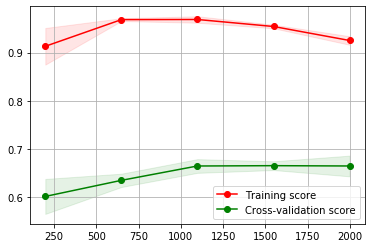

'fold 4/4'

1    2255
0     743
Name: df, dtype: int64

accuracy 0.6603206412825652
recall 0.758988015978695
precision 0.782967032967033

confusion matrix:
 [[ 89 158]
 [181 570]]
              precision    recall  f1-score   support

           0       0.33      0.36      0.34       247
           1       0.78      0.76      0.77       751

    accuracy                           0.66       998
   macro avg       0.56      0.56      0.56       998
weighted avg       0.67      0.66      0.67       998



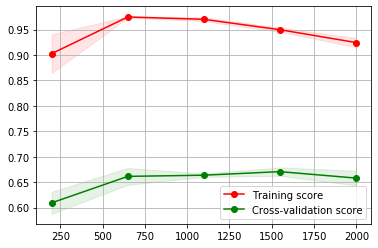

In [21]:
# Drop redundant columns and try the same classifier (same params) again

# Results: same as bad

dropped_features_train_df = train_df.drop( features_to_drop, axis=1 )

try_model(
    dropped_features_train_df, enc_train_labels
)

In [35]:
# Try oversampling

# Use imblearn.over_sampling.SMOTE to resample target feature

def try_model_smote( data_df, target_df ):
    skf = StratifiedKFold(
        n_splits=4,
        shuffle=True
    )

    idx = 0
    for train_idx, val_idx in skf.split(data_df, target_df):
        X_tr, X_val = data_df.iloc[train_idx, :], data_df.iloc[val_idx, :]
        y_tr, y_val = target_df.iloc[train_idx], target_df.iloc[val_idx]

        sm = SMOTE(ratio=0.75)
        X_tr_res, y_tr_res = sm.fit_sample( X_tr, y_tr )

#         display(pd.Series(y_tr_res).value_counts())
       
        idx += 1
        display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))

        lgbm_model = LGBMClassifier(
            metric='binary_error',
            objective='binary',
            n_estimators=250,
            learning_rate=0.05,
            scale_pos_weight=0.75,
            n_jobs=4,
        )
        lgbm_model.fit(X_tr_res, y_tr_res)

        val_y_pred = lgbm_model.predict(X_val)
        print( 'accuracy', lgbm_model.score(X_val, y_val) )
        print( 'recall', recall_score(y_val, val_y_pred ) )
        print( 'precision', precision_score(y_val, val_y_pred) )
        print( '\nconfusion matrix:\n', confusion_matrix(y_val, val_y_pred) )
        print( classification_report(y_val, val_y_pred) )
        
        draw_learning_curve( lgbm_model, X_tr_res, y_tr_res )        

    return lgbm_model

'fold 1/4'

accuracy 0.726
recall 0.925531914893617
precision 0.7614879649890591

confusion matrix:
 [[ 30 218]
 [ 56 696]]
              precision    recall  f1-score   support

           0       0.35      0.12      0.18       248
           1       0.76      0.93      0.84       752

    accuracy                           0.73      1000
   macro avg       0.56      0.52      0.51      1000
weighted avg       0.66      0.73      0.67      1000



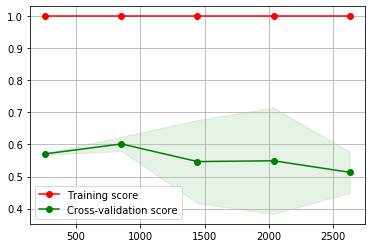

'fold 2/4'

accuracy 0.733
recall 0.9414893617021277
precision 0.7604726100966702

confusion matrix:
 [[ 25 223]
 [ 44 708]]
              precision    recall  f1-score   support

           0       0.36      0.10      0.16       248
           1       0.76      0.94      0.84       752

    accuracy                           0.73      1000
   macro avg       0.56      0.52      0.50      1000
weighted avg       0.66      0.73      0.67      1000



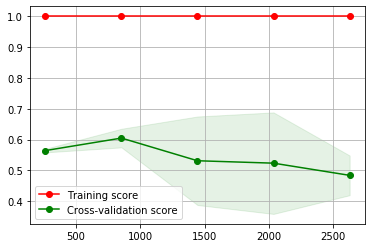

'fold 3/4'

accuracy 0.7224448897795591
recall 0.9254327563249002
precision 0.7587336244541485

confusion matrix:
 [[ 26 221]
 [ 56 695]]
              precision    recall  f1-score   support

           0       0.32      0.11      0.16       247
           1       0.76      0.93      0.83       751

    accuracy                           0.72       998
   macro avg       0.54      0.52      0.50       998
weighted avg       0.65      0.72      0.67       998



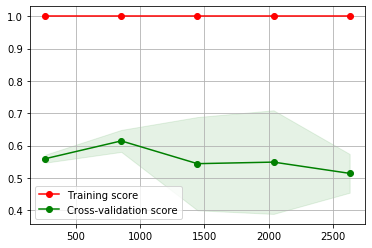

'fold 4/4'

accuracy 0.7234468937875751
recall 0.9227696404793608
precision 0.7607025246981339

confusion matrix:
 [[ 29 218]
 [ 58 693]]
              precision    recall  f1-score   support

           0       0.33      0.12      0.17       247
           1       0.76      0.92      0.83       751

    accuracy                           0.72       998
   macro avg       0.55      0.52      0.50       998
weighted avg       0.65      0.72      0.67       998



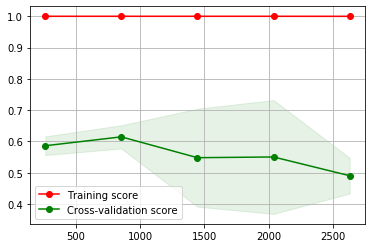

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='binary_error', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=250,
               n_jobs=4, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=0.75,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [36]:
try_model_smote( train_df, enc_train_labels )

In [37]:
# Try randomforestclf without SMOTE

from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(
    n_splits=4,
    shuffle=True
)

idx = 0
for train_idx, val_idx in skf.split(train_df, enc_train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = enc_train_labels.iloc[train_idx], enc_train_labels.iloc[val_idx]

    idx += 1
    display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))

    rfc = RandomForestClassifier(
        n_jobs=-1
    )
    rfc.fit( X_tr, y_tr )

    val_y_pred = rfc.predict(X_val)
    print( 'accuracy', rfc.score(X_val, y_val) )
    print( 'recall', recall_score(y_val, val_y_pred ) )
    print( 'precision', precision_score(y_val, val_y_pred) )
    print( '\nconfusion matrix:\n', confusion_matrix(y_val, val_y_pred) )
    print( classification_report(y_val, val_y_pred) )

'fold 1/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.705
recall 0.8789893617021277
precision 0.7641618497109827

confusion matrix:
 [[ 44 204]
 [ 91 661]]
              precision    recall  f1-score   support

           0       0.33      0.18      0.23       248
           1       0.76      0.88      0.82       752

    accuracy                           0.70      1000
   macro avg       0.55      0.53      0.52      1000
weighted avg       0.66      0.70      0.67      1000



'fold 2/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.698
recall 0.8882978723404256
precision 0.7539503386004515

confusion matrix:
 [[ 30 218]
 [ 84 668]]
              precision    recall  f1-score   support

           0       0.26      0.12      0.17       248
           1       0.75      0.89      0.82       752

    accuracy                           0.70      1000
   macro avg       0.51      0.50      0.49      1000
weighted avg       0.63      0.70      0.65      1000



'fold 3/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.7164328657314629
recall 0.8974700399467377
precision 0.7659090909090909

confusion matrix:
 [[ 41 206]
 [ 77 674]]
              precision    recall  f1-score   support

           0       0.35      0.17      0.22       247
           1       0.77      0.90      0.83       751

    accuracy                           0.72       998
   macro avg       0.56      0.53      0.53       998
weighted avg       0.66      0.72      0.68       998



'fold 4/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.6813627254509018
recall 0.8641810918774967
precision 0.7502890173410405

confusion matrix:
 [[ 31 216]
 [102 649]]
              precision    recall  f1-score   support

           0       0.23      0.13      0.16       247
           1       0.75      0.86      0.80       751

    accuracy                           0.68       998
   macro avg       0.49      0.49      0.48       998
weighted avg       0.62      0.68      0.64       998



'fold 1/4'

accuracy 0.754
recall 0.9853723404255319
precision 0.7592213114754098

confusion matrix:
 [[ 13 235]
 [ 11 741]]
              precision    recall  f1-score   support

           0       0.54      0.05      0.10       248
           1       0.76      0.99      0.86       752

    accuracy                           0.75      1000
   macro avg       0.65      0.52      0.48      1000
weighted avg       0.71      0.75      0.67      1000



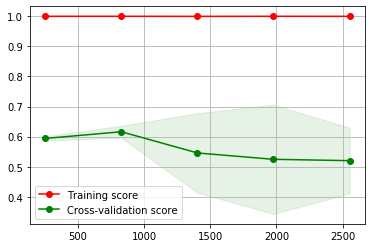

'fold 2/4'

accuracy 0.74
recall 0.9747340425531915
precision 0.7525667351129364

confusion matrix:
 [[  7 241]
 [ 19 733]]
              precision    recall  f1-score   support

           0       0.27      0.03      0.05       248
           1       0.75      0.97      0.85       752

    accuracy                           0.74      1000
   macro avg       0.51      0.50      0.45      1000
weighted avg       0.63      0.74      0.65      1000



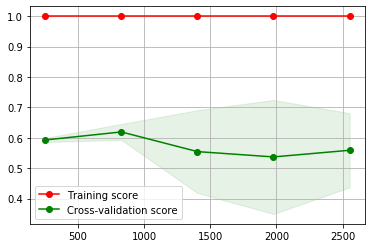

'fold 3/4'

accuracy 0.7525050100200401
recall 0.9866844207723036
precision 0.7576687116564417

confusion matrix:
 [[ 10 237]
 [ 10 741]]
              precision    recall  f1-score   support

           0       0.50      0.04      0.07       247
           1       0.76      0.99      0.86       751

    accuracy                           0.75       998
   macro avg       0.63      0.51      0.47       998
weighted avg       0.69      0.75      0.66       998



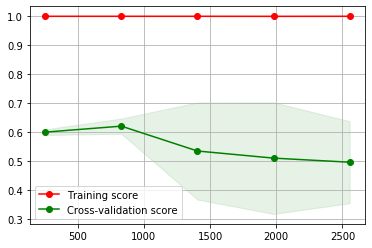

'fold 4/4'

accuracy 0.7434869739478958
recall 0.9800266311584553
precision 0.7533265097236438

confusion matrix:
 [[  6 241]
 [ 15 736]]
              precision    recall  f1-score   support

           0       0.29      0.02      0.04       247
           1       0.75      0.98      0.85       751

    accuracy                           0.74       998
   macro avg       0.52      0.50      0.45       998
weighted avg       0.64      0.74      0.65       998



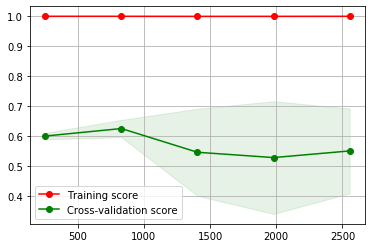

In [58]:
# Try randomforestclf with SMOTE

skf = StratifiedKFold(
    n_splits=4,
    shuffle=True
)

idx = 0
for train_idx, val_idx in skf.split(train_df, enc_train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = enc_train_labels.iloc[train_idx], enc_train_labels.iloc[val_idx]
    
    sm = SMOTE(ratio=0.7)
    X_tr_res, y_tr_res = sm.fit_sample( X_tr, y_tr )

#     display(pd.Series(y_tr_res).value_counts())
#     display(pd.Series(y_tr).value_counts())

    idx += 1
    display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))

    rfc = RandomForestClassifier(
        n_estimators=50,
        n_jobs=-1
    )
    rfc.fit( X_tr_res, y_tr_res )

    val_y_pred = rfc.predict(X_val)
    print( 'accuracy', rfc.score(X_val, y_val) )
    print( 'recall', recall_score(y_val, val_y_pred ) )
    print( 'precision', precision_score(y_val, val_y_pred) )
    print( '\nconfusion matrix:\n', confusion_matrix(y_val, val_y_pred) )
    print( classification_report(y_val, val_y_pred) )
    
    draw_learning_curve( rfc, X_tr_res, y_tr_res )

In [39]:
# weighted classes

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight( 'balanced', np.unique( enc_train_labels ), enc_train_labels )

'fold 1/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.708
recall 0.9002659574468085
precision 0.7572706935123042

confusion matrix:
 [[ 31 217]
 [ 75 677]]
              precision    recall  f1-score   support

           0       0.29      0.12      0.18       248
           1       0.76      0.90      0.82       752

    accuracy                           0.71      1000
   macro avg       0.52      0.51      0.50      1000
weighted avg       0.64      0.71      0.66      1000



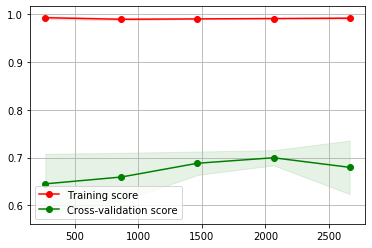

'fold 2/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.732
recall 0.9361702127659575
precision 0.7619047619047619

confusion matrix:
 [[ 28 220]
 [ 48 704]]
              precision    recall  f1-score   support

           0       0.37      0.11      0.17       248
           1       0.76      0.94      0.84       752

    accuracy                           0.73      1000
   macro avg       0.57      0.52      0.51      1000
weighted avg       0.66      0.73      0.67      1000



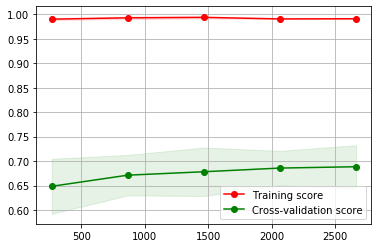

'fold 3/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.7094188376753507
recall 0.8961384820239681
precision 0.7604519774011299

confusion matrix:
 [[ 35 212]
 [ 78 673]]
              precision    recall  f1-score   support

           0       0.31      0.14      0.19       247
           1       0.76      0.90      0.82       751

    accuracy                           0.71       998
   macro avg       0.54      0.52      0.51       998
weighted avg       0.65      0.71      0.67       998



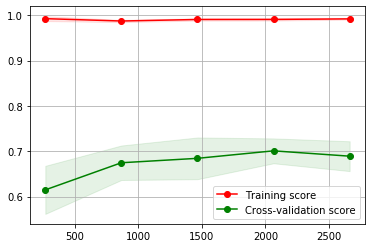

'fold 4/4'

/home/max/.conda/envs/studyingenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.7124248496993988
recall 0.9107856191744341
precision 0.7566371681415929

confusion matrix:
 [[ 27 220]
 [ 67 684]]
              precision    recall  f1-score   support

           0       0.29      0.11      0.16       247
           1       0.76      0.91      0.83       751

    accuracy                           0.71       998
   macro avg       0.52      0.51      0.49       998
weighted avg       0.64      0.71      0.66       998



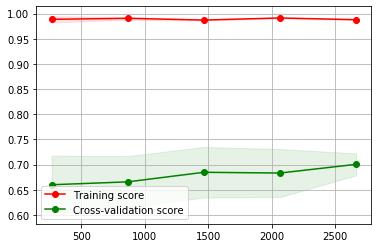

In [40]:
# Try RFC with weighted classes, without SMOTE

# Try randomforestclf without SMOTE

skf = StratifiedKFold(
    n_splits=4,
    shuffle=True
)

idx = 0
for train_idx, val_idx in skf.split(train_df, enc_train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = enc_train_labels.iloc[train_idx], enc_train_labels.iloc[val_idx]

    idx += 1
    display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))

    rfc = RandomForestClassifier(
        max_depth=50,
        class_weight='balanced',
        criterion='entropy',
        n_jobs=-1
    )
    rfc.fit( X_tr, y_tr )

    val_y_pred = rfc.predict(X_val)
    print( 'accuracy', rfc.score(X_val, y_val) )
    print( 'recall', recall_score(y_val, val_y_pred ) )
    print( 'precision', precision_score(y_val, val_y_pred) )
    print( '\nconfusion matrix:\n', confusion_matrix(y_val, val_y_pred) )
    print( classification_report(y_val, val_y_pred) )

    draw_learning_curve( rfc, train_df, enc_train_labels )

'fold 1/4'

accuracy 0.641
recall 0.7393617021276596
precision 0.7732962447844228

confusion matrix:
 [[ 85 163]
 [196 556]]
              precision    recall  f1-score   support

           0       0.30      0.34      0.32       248
           1       0.77      0.74      0.76       752

    accuracy                           0.64      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.66      0.64      0.65      1000



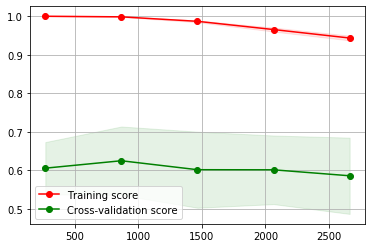

'fold 2/4'

accuracy 0.642
recall 0.7273936170212766
precision 0.7814285714285715

confusion matrix:
 [[ 95 153]
 [205 547]]
              precision    recall  f1-score   support

           0       0.32      0.38      0.35       248
           1       0.78      0.73      0.75       752

    accuracy                           0.64      1000
   macro avg       0.55      0.56      0.55      1000
weighted avg       0.67      0.64      0.65      1000



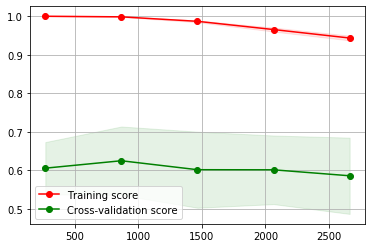

'fold 3/4'

accuracy 0.6312625250501002
recall 0.7323568575233023
precision 0.7670850767085077

confusion matrix:
 [[ 80 167]
 [201 550]]
              precision    recall  f1-score   support

           0       0.28      0.32      0.30       247
           1       0.77      0.73      0.75       751

    accuracy                           0.63       998
   macro avg       0.53      0.53      0.53       998
weighted avg       0.65      0.63      0.64       998



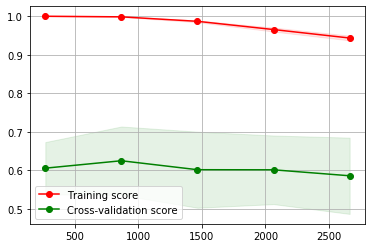

'fold 4/4'

accuracy 0.627254509018036
recall 0.7070572569906791
precision 0.7774524158125915

confusion matrix:
 [[ 95 152]
 [220 531]]
              precision    recall  f1-score   support

           0       0.30      0.38      0.34       247
           1       0.78      0.71      0.74       751

    accuracy                           0.63       998
   macro avg       0.54      0.55      0.54       998
weighted avg       0.66      0.63      0.64       998



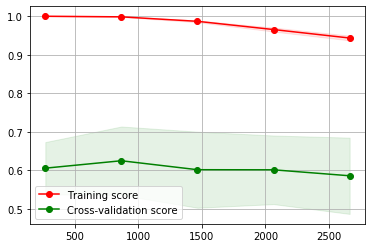

In [47]:
# Try out xgboost classifier

from xgboost import XGBClassifier

skf = StratifiedKFold(
    n_splits=4,
    shuffle=True
)

idx = 0
for train_idx, val_idx in skf.split(train_df, enc_train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = enc_train_labels.iloc[train_idx], enc_train_labels.iloc[val_idx]

    idx += 1
    display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))
    
    xgb_clf = XGBClassifier(
        eval_metric='auc',
        n_estimators=400,
        scale_pos_weight=0.32,
        learning_rate=0.15,
        n_jobs=-1
    )
    xgb_clf.fit( X_tr, y_tr )

    val_y_pred = xgb_clf.predict(X_val)
    print( 'accuracy', xgb_clf.score(X_val, y_val) )
    print( 'recall', recall_score(y_val, val_y_pred ) )
    print( 'precision', precision_score(y_val, val_y_pred) )
    print( '\nconfusion matrix:\n', confusion_matrix(y_val, val_y_pred) )
    print( classification_report(y_val, val_y_pred) )

    draw_learning_curve( xgb_clf, train_df, enc_train_labels )

In [69]:
from sklearn.metrics import roc_curve, auc

In [72]:
# Blend xgb, lgbm and rfc and estimate log-loss

skf = StratifiedKFold(
    n_splits=4,
    shuffle=True
)

idx = 0
for train_idx, val_idx in skf.split(train_df, enc_train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = enc_train_labels.iloc[train_idx], enc_train_labels.iloc[val_idx]

    sm = SMOTE(ratio=0.75)
    X_tr_res, y_tr_res = sm.fit_sample( X_tr, y_tr )
    
    idx += 1
    display('fold {0}/{1}'.format( idx, skf.get_n_splits() ))
    
#     display(pd.Series(y_tr).value_counts())  # 0.329192
#     display(pd.Series(y_tr_res).value_counts())  # 0.749778
    
    lgbm_model = LGBMClassifier(
        metric='binary_logloss',
        objective='binary',
        n_estimators=250,
        learning_rate=0.05,
        scale_pos_weight=0.75,
        n_jobs=4,
    )
    lgbm_model.fit(X_tr_res, y_tr_res)
    lgbm_pred_proba = lgbm_model.predict_proba(X_val)
    
    xgb_clf = XGBClassifier(
        eval_metric='auc',
        n_estimators=400,
        scale_pos_weight=0.32,
        learning_rate=0.15,
        n_jobs=-1
    )
    xgb_clf.fit( X_tr, y_tr )
    xgb_pred_proba = xgb_clf.predict_proba(X_val)

    rfc_clf = RandomForestClassifier(
        n_estimators=50,
        n_jobs=-1
    )
    rfc_clf.fit( X_tr_res, y_tr_res )
    rfc_pred_proba = rfc_clf.predict_proba(X_val)

    MODELS_CNT = 3
    pred_proba = (lgbm_pred_proba + xgb_pred_proba + rfc_pred_proba) / MODELS_CNT

    display( 'log loss:', log_loss( y_val, pred_proba ) )
    
    fpr, tpr, thresholds = roc_curve( y_val, pred_proba[:, 0] )
    
    display( 'auc:', )
    
    break

'fold 1/4'

'log loss:'

0.5556773044680535

[0.48602676 0.40213294 0.37150173 0.40279368 0.27154923 0.562899
 0.14115867 0.23266486 0.2547963  0.11910241 0.12224798 0.42904143
 0.4810595  0.38364581 0.48183612 0.19175542 0.3024891  0.47933381
 0.30067896 0.08974764 0.23261472 0.21957291 0.19579204 0.15426631
 0.42535607 0.2960409  0.20406986 0.20617111 0.17975852 0.52182421
 0.15982078 0.29917698 0.10912984 0.38991972 0.38438522 0.43396811
 0.22881909 0.26421962 0.18932945 0.36035344 0.39263201 0.41863549
 0.29968813 0.26572826 0.38386768 0.24376312 0.51654518 0.49432952
 0.40026071 0.18746313 0.50562689 0.48231007 0.5638463  0.39392302
 0.19566255 0.49120062 0.15333696 0.42440986 0.62302841 0.34270534
 0.44264367 0.26916807 0.34399093 0.19774986 0.21830842 0.25340374
 0.22814734 0.57196658 0.43103906 0.23959307 0.29391256 0.17777309
 0.06896588 0.51634769 0.17039869 0.34987002 0.23703429 0.1398104
 0.13387847 0.3281965  0.33651983 0.30798301 0.49673741 0.31835259
 0.46878328 0.49395831 0.08105979 0.2287473  0.26751602 0.2279996